# Hubble Law Part 1: Extragalactic Redshift


## Objective: 
---

In the 1920's, there was a debate between astronomers on the existence of galaxies, or what they referred to as 'Island universes'. Known as the Great Debate, Harlow Shapley and Heber Curtis were at odds on origins of spiral galaxies. One thinking that these nebulae like objects are held within our galaxy, which was believed to be the entirety of our universe at the time, whereas the other postulated that their distances spanned much further than our milky way. It wasn't until Edwin P. Hubble discovered that distant galaxies were all moving away from the Milky Way (and the Local Group) that astronomers started to believe that these extragalactic objects existed. Not only that, the farther away he observed, the faster the objects were receding. He found the relationship that is now known as Hubble's Law: the recessional velocity of a galaxy is proportional to its distance from us,

 $$v = H_{0} \cdot d$$

Where  is the velocity along the observers line of sight in km/s,  is the distance to the object in parsecs, and  is the notorious Hubble constant. In our more modern context of astronomy, the Hubble constant is a fundamental constant indicating the expansion rate of spacetime and the age of our universe as a whole, and is studied extensively in the field of Cosmology. The value of the Hubble constant has seen drastic revisions throughout the last century. Even today there isn't a consensus. This is largely due to how involved the Hubble constant is within various fields of astronomy & cosmology. It shows up in the Cosmic Microwave Background (CMB), Structure Formation of the universe, as well as our standard candles (Cephiads, SNIa, etc). This is highlighted in Fig. (1).

[put image from folder here]

Today's measurements of the Hubble constant are far more sophisticated than that of Hubble's original calculation. His original calculations put the Hubble constant to around 500 km/s/Mpc, more than five times current values. The reason for this discrepancy is our poor understanding of galactic distances in the early 20th century. At the time, galaxies were assumed to be much closer to us than where we know them to be today. This lab will focus on using similar methods to determining both the velocity and distances of galaxies in an attempt to calculate the Hubble constant. Let's see if we can do better than Hubble.

In [1]:
import pandas as pd            #for our data structuress
import numpy as np             #for manipulating data
import matplotlib as mpl       #for visualization
import scipy as sp             #for chi2 model fitting/minimization
import os

### Finding Radial Velocities of Galaxies:


The velocity is relatively easy for us to measure using the Doppler effect. An object in motion (in this case, being carried along by the expansion of space itself) will have its radiation (light) shifted in wavelength. For velocities much smaller than the speed of light, we can use the regular Doppler formula: 

$$\frac{\lambda - \lambda_0}{\lambda_0} = \frac{v}{c}$$

Where  is the measured wavelength,  is the wavelength measured in the rest frame,  is the velocity along that line of sight (radial velocity), and  is the speed of light. The quantity on the left side of this equation is usually called the redshift, and is denoted by the letter z. The velocity of the galaxy is determined by measuring the redshift of spectral lines in the spectrum of the galaxy. Most galaxies are rich in spectral features: the "K and H" lines of ionized calcium and the H-alpha line of hydrogen. 

Let's start by reading in the spectral data of a single galaxy and try to automate the process once we have a grasp on the process.Load a single raw data file of Normalized flux (column 1) and wavelength in Angstroms (column 2).

In [2]:
directory = 'NGCData/Spectra/';
files = (file for file in os.listdir(directory) 
         if os.path.isfile(os.path.join(directory, file)))

file = [directory + f for f in files]

Until the very end of the lab we'll use a single file to visualize our method of approach before we apply it to the entire dataset

In [3]:
test_set = file[6]

data = np.loadtxt(test_set)
wavelength = data[:,0]
normal_flux = data[:,1]

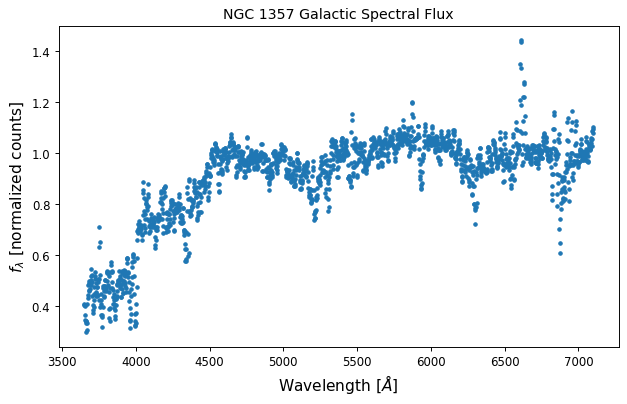

In [4]:
%matplotlib inline
fig, ax = mpl.pyplot.subplots(figsize=(8.5, 5), dpi=85)

ax.scatter(wavelength, normal_flux, s = 8, label = "Raw Data");
ax.set_title("NGC 1357 Galactic Spectral Flux", fontsize=12);
ax.set_xlabel('Wavelength [$\AA$]', fontsize=13);
ax.set_ylabel('$f_{\lambda}$ [normalized counts]', fontsize=13);

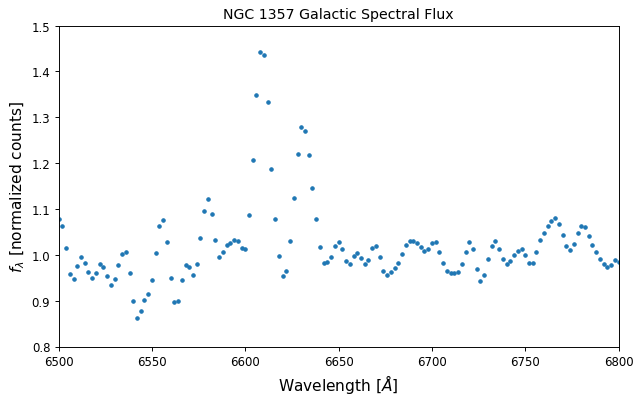

In [5]:
ax.set_xlim([6500,6800]);
ax.set_ylim([.8,1.5]);
fig

### Smoothing the Spectra:

Not all of the lines come from the light of the galaxy. Each spectrum contains noise; we just cannot get away from it. You should notice that some of the spectra are much "noisier" than other spectra. This noise tends to hamper accurate identification of some of the lines. We can smooth out the function using a smoothing function; in this case, a N-point moving average smoother (we'll use 5-point) is build into scipy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.uniform_filter1d.html

$$y'(n) = (y(n-2) + y(n-1) + y(n) + y(n+1) + y(n+2))/5$$

In [6]:
from scipy.interpolate import make_interp_spline
from scipy.ndimage.filters import uniform_filter1d

Spline = make_interp_spline(wavelength, normal_flux)
smooth_flux = Spline(wavelength)

y = uniform_filter1d(normal_flux, size = 5)

Now plot the smoothed data on top of the original data to see if we can identify the lines better. Knowing visually where the unshifted hyrdrogen alpha line will make the inspection process easier for us. To do this, we'll add an annotated vertical line to overlay on our plot using xline(value).

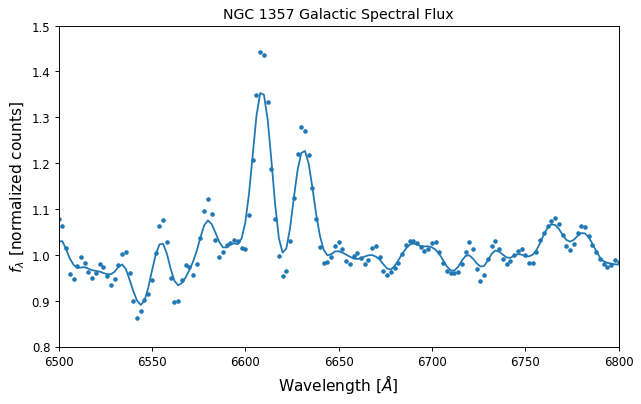

In [7]:
ax.plot(wavelength, y, label = "Smoothed data");
fig

### Finding the Peaks:


Looking at the smoothed data we can easily point out the various emission and absorption lines of the galaxy. In our case, we're concerned with only the hydrogen alpha line which is an emission line. We can focus our attention on trying to find all of the maximums of the data instead of the minimum. It may look like a daunting task, luckily scipy provides us with in house peak finding algorithms, in the form of find_peaks(data). It takes in our (smoothed) data and gives pack multiple arguments, in order:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

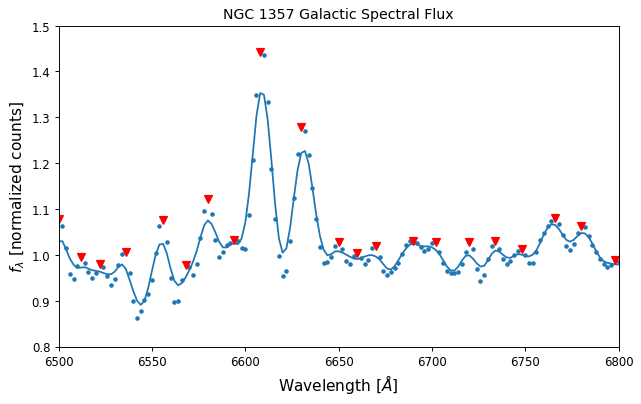

In [8]:
from scipy.signal import find_peaks
peaks, properties = find_peaks(smooth_flux)

peak_wavelength = wavelength[peaks]
peak_flux = smooth_flux[peaks]

ax.plot(peak_wavelength[220:], smooth_flux[220:],'rv')
fig